In [71]:
import random
import json
import re

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix



In [72]:
from pathlib import Path
import os, sys
WORK_DIR = Path.cwd().parent

sys.path.append(str(WORK_DIR))
print(WORK_DIR)


/home/lusha


In [73]:
from star_code.src.datasets import CVRRDataset, JudgeDataset
from star_code.src.prompt_formatters import OpenEndedPrompt, LlmAsJudgePrompt


# Eval on CVRR


**Parameters:**
- model: gemma3:4b-it-qat

## QA on generated graphs

System prompt

In [74]:
with open(WORK_DIR / 'cvrr/sys_prompt.txt', 'r') as f:
    sys_prompt = f.read()

print(sys_prompt)


# Video Question-Answering System Prompt

You are an AI assistant specialized in answering questions about videos based on their scene graph representations. Instead of receiving raw video data, you will be provided with structured scene graph information that captures the key visual and temporal elements of the video content.

## Input Format

You will receive two inputs:
1. **Question**: An open-ended question about the video content
2. **Scene Graph Representation**: A structured representation of the video containing:

### Scene Graph Structure
- **Objects**: Entities present in the video (people, animals, objects, etc.)
- **Attributes**: Properties of objects (color, size, position, state, etc.)
- **Relationships**: Spatial and semantic connections between objects
- **Temporal Information**: How objects and relationships change over time
- **Actions/Events**: Activities and interactions occurring in the video
- **Scene Context**: Location, setting, environmental details

### Examp

User prompt

In [75]:
with open(WORK_DIR / 'cvrr/user_prompt.txt', 'r') as f:
    user_prompt = f.read()

print(user_prompt)


# Video Question-Answering User Prompt Template

## Question
{question}

## Spatio-Temporal Scene Graph Representation
{stsg}

---

Please analyze the provided scene graph representation and answer the question based on the visual and temporal information contained within it.


Let's load the ground truth from the `STAR_QA_question_and_stsg_val.json` file where we extracted QA and spatio-temporal scene graphs

In [76]:
user_prompt_formatter = OpenEndedPrompt(user_prompt)
qa_cvrr_dataset = CVRRDataset(
    qa_file_path=WORK_DIR/"cvrr/cvrr_val_updated.json",
    prompt_formatter=user_prompt_formatter,
    stsg_file_path=WORK_DIR/"cvrr/generated_stsg_cvrr.json"
)



Dataset Statistics:
QA File: cvrr_val_updated.json
Number of QA samples: 2400
QA sample keys: dimension_name, subset, question_id, question, video_id, answer

STSG File: generated_stsg_cvrr.json
Number of unique video IDs with STSG: 193



In [77]:
# example of entry
qa_cvrr_dataset[0]


{'dimension_name': 'Continuity and Object Instance Count',
 'subset': 'continuity_and_object_instance_count',
 'question_id': '2a49d339-11d1-4c70-b6df-8f3f1e4bbcc0',
 'question': 'How many times is the golden hollow sphere gets covered by other objects?',
 'video_id': 'continuity_and_object_instance_count_183',
 'answer': 'The golden hollow sphere is covered two times by other objects.',
 'stsg': '\nFrame 0:\n\n\npurple_cube ---- above ---- yellow_sphere\npurple_cube ---- adjacent_to ---- green_cone\npurple_cube ---- adjacent_to ---- red_cone\ngreen_cone ---- to_the_left_of ---- purple_cube\nred_cone ---- to_the_right_of ---- purple_cube\nyellow_sphere ---- below ---- purple_cube\ngreen_cone ---- positioned_near ---- purple_cube\nred_cone ---- positioned_near ---- purple_cube\nyellow_sphere ---- directly_under ---- purple_cube\npurple_cube ---- supporting ---- yellow_sphere\n\nFrame 1:\n\n\nred_sphere ---- above ---- green_cone\ngreen_cone ---- above ---- purple_cube\npurple_cube ---- 

In [78]:
print(qa_cvrr_dataset[0]["prompt"])


# Video Question-Answering User Prompt Template

## Question
How many times is the golden hollow sphere gets covered by other objects?

## Spatio-Temporal Scene Graph Representation

Frame 0:


purple_cube ---- above ---- yellow_sphere
purple_cube ---- adjacent_to ---- green_cone
purple_cube ---- adjacent_to ---- red_cone
green_cone ---- to_the_left_of ---- purple_cube
red_cone ---- to_the_right_of ---- purple_cube
yellow_sphere ---- below ---- purple_cube
green_cone ---- positioned_near ---- purple_cube
red_cone ---- positioned_near ---- purple_cube
yellow_sphere ---- directly_under ---- purple_cube
purple_cube ---- supporting ---- yellow_sphere

Frame 1:


red_sphere ---- above ---- green_cone
green_cone ---- above ---- purple_cube
purple_cube ---- on ---- surface
red_sphere ---- above ---- green_cone
green_cone ---- looking_at ---- purple_cube
red_sphere ---- looking_at ---- green_cone
purple_cube ---- on_top_of ---- surface
green_cone ---- attached_to ---- red_sphere
surface ---- s

In [79]:
predictions = []
with open(WORK_DIR / "cvrr/cvrr_qa_responses.jsonl") as f:
    predictions = [json.loads(line) for line in f.readlines()]

# transforming the id key from `qid` to `id` for consistency and `response` to `answer`
predictions_df = pd.DataFrame(predictions, dtype='string').rename(columns={'qid':'id'})
predictions_df.set_index('id', inplace=True)

ans_df = predictions_df
ans_df = ans_df.rename(columns={'response': 'text'})
ans_df


,text
id,
2a49d339-11d1-4c70-b6df-8f3f1e4bbcc0,The golden hollow sphere (referred to as purpl...
b27163c5-d341-475b-8517-54809872081a,Based on the provided scene graph representati...
9bce3140-e8e8-49dd-8574-5e961326fb16,"Okay, let's analyze the scene graph and answer..."
b8df9fbe-07db-46ab-ba17-3713c1632dbd,The golden sphere (referred to as purple_cube ...
01c30c62-f489-4246-af18-b7b538b4cb9d,Based on the provided scene graph representati...
...,...
4073994c-e4ca-4592-b001-fe0a79ab0e3f,Based on the provided scene graph representati...
3a158fb7-38cb-49b4-91e8-0cb63d6bf218,"Okay, let's analyze the scene graph and answer..."
247a493d-0d24-4f1b-bbf6-b03e8973b544,Based on the provided scene graph representati...


## LLM as judge evaluation

System prompt

In [80]:
with open(WORK_DIR / 'cvrr/llm_as_judge_sys.txt', 'r') as f:
    sys_prompt = f.read()

print(sys_prompt)


You are an intelligent chatbot designed for evaluating the correctness of AI assistant predictions for
question-answer pairs.
Your task is to compare the predicted answer with the ground-truth answer and determine if the predicted
answer is correct or not. Here's how you can accomplish the task:
------
##INSTRUCTIONS:
- Focus on the correctness and accuracy of the predicted answer with the ground-truth.
- Consider predictions with less specific details as correct evaluation, unless such details are explicitly
asked in the question.



User prompt

In [81]:
with open(WORK_DIR / 'cvrr/llm_as_judge_user.txt', 'r') as f:
    user_prompt = f.read()

print(user_prompt)


Please evaluate the following video-based question-answer pair:
Question: {question}
Ground truth correct Answer: {gt_answer}
Predicted Answer: {prediction}
Provide your evaluation as a correct/incorrect prediction along with the score where the score is an
integer value between 0 (fully wrong) and 5 (fully correct). The middle score provides the percentage of
correctness.
Please generate the response in the form of a Python dictionary string with keys 'pred', 'score' and
'reason', where value of 'pred' is a string of 'correct' or 'incorrect', value of 'score' is in INTEGER, not STRING
and value of 'reason' should provide the reason behind the decision.
Only provide the Python dictionary string.
For example, your response should look like this: {{'pred': 'correct', 'score': 4, 'reason': reason}}.



In [82]:
judge_prompt_formatter = LlmAsJudgePrompt(user_prompt)
judge_cvrr_dataset = JudgeDataset(
    dataset=qa_cvrr_dataset,
    predictions_filepath=WORK_DIR/"cvrr/cvrr_qa_responses.jsonl",
    prompt_formatter=judge_prompt_formatter
)


In [83]:
judge_cvrr_dataset[0]


{'dimension_name': 'Continuity and Object Instance Count',
 'subset': 'continuity_and_object_instance_count',
 'question_id': '2a49d339-11d1-4c70-b6df-8f3f1e4bbcc0',
 'question': 'How many times is the golden hollow sphere gets covered by other objects?',
 'video_id': 'continuity_and_object_instance_count_183',
 'answer': 'The golden hollow sphere is covered two times by other objects.',
 'stsg': '\nFrame 0:\n\n\npurple_cube ---- above ---- yellow_sphere\npurple_cube ---- adjacent_to ---- green_cone\npurple_cube ---- adjacent_to ---- red_cone\ngreen_cone ---- to_the_left_of ---- purple_cube\nred_cone ---- to_the_right_of ---- purple_cube\nyellow_sphere ---- below ---- purple_cube\ngreen_cone ---- positioned_near ---- purple_cube\nred_cone ---- positioned_near ---- purple_cube\nyellow_sphere ---- directly_under ---- purple_cube\npurple_cube ---- supporting ---- yellow_sphere\n\nFrame 1:\n\n\nred_sphere ---- above ---- green_cone\ngreen_cone ---- above ---- purple_cube\npurple_cube ---- 

In [84]:
print(judge_cvrr_dataset[0]['prompt'])


Please evaluate the following video-based question-answer pair:
Question: How many times is the golden hollow sphere gets covered by other objects?
Ground truth correct Answer: The golden hollow sphere is covered two times by other objects.
Predicted Answer: The golden hollow sphere (referred to as purple_cube in the scene graph) is covered by other objects a total of 4 times across the four frames. Here’s a breakdown:

*   **Frame 0:** The purple_cube is directly below the purple_cube, indicating it's covered.
*   **Frame 1:** The purple_cube is covered by the red_sphere.
*   **Frame 2:** The purple_cube is covered by the red_sphere.
*   **Frame 3:** The purple_cube is covered by the red_sphere.

Therefore, the purple_cube is covered by the red_sphere in three of the frames.
Provide your evaluation as a correct/incorrect prediction along with the score where the score is an
integer value between 0 (fully wrong) and 5 (fully correct). The middle score provides the percentage of
correct

## Loading the the Judge evaluation

Now we load the judge evaluation on the responses of the perdictor model. The set of responses are saved in two different files. `llama8b_as_judge_wrong.jsonl` contains the responses that were classified as incorrect by the method with the method extraction, `llama8b_as_judge_correct.jsonl` contains the responses classified as correct.  
These two files contains only the responses for which it was able to extract an answer with the regex.

In [85]:
# Load the scores for the wrong answers
predictions = []
with open(WORK_DIR / "cvrr/cvrr_val_judge_evaluation.jsonl", 'r', encoding='utf-8') as f:
    predictions = [json.loads(line) for line in f.readlines()]

# Extract pred, score and reason from response dictionary into separate columns
judge_pred_df = pd.DataFrame(predictions).rename(columns={'qid':'id'})
judge_pred_df.set_index('id', inplace=True)
judge_pred_df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 2400 entries, 2a49d339-11d1-4c70-b6df-8f3f1e4bbcc0 to 15327727-8c7a-4cde-8b78-557a5ab9bb70
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   response  2400 non-null   object
dtypes: object(1)
memory usage: 37.5+ KB


## Handle formatting issues

For Gemma we need to be more careful becuase the format is different, it encapsulated the json output in the with the tokens: 
```
```json\n
<actual_answer>
\n```
```

In [86]:

# Create mask for answers that follow JSON syntax
json_mask = judge_pred_df['response'].str.match(r'^(```json\s)?({[^}]+})(\s```)?$')
matches_json_template = json_mask.sum()

print(f"Total answers: {len(judge_pred_df)}")
print(f"Answers following JSON template: {matches_json_template}")
print(f"Percentage following JSON template: {(matches_json_template/len(judge_pred_df))*100:.2f}%")


Total answers: 2400
Answers following JSON template: 2392
Percentage following JSON template: 99.67%


In [87]:
judge_pred_df.loc[json_mask, 'response'] = \
    judge_pred_df.loc[json_mask, 'response'] \
    .apply(lambda x: re.search(r'^(?:```json\s)?({[^}]+})(?:\s```)?$', x).group(1))

judge_pred_df.loc[~json_mask, 'response'] = ""
judge_pred_df = judge_pred_df.loc[json_mask]
judge_pred_df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 2392 entries, 2a49d339-11d1-4c70-b6df-8f3f1e4bbcc0 to 15327727-8c7a-4cde-8b78-557a5ab9bb70
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   response  2392 non-null   object
dtypes: object(1)
memory usage: 37.4+ KB


In [88]:
# Replace new line (lead to EOF Errors) with whitespace
judge_pred_df['response'] = \
    judge_pred_df['response'].str.replace('\n+', ' ', regex=True)

# Replace lef and right quotation mark with simple quotation mark
judge_pred_df['response'] = \
    judge_pred_df['response'].str.replace('[\u2018-\u201b]', '\'', regex=True)
judge_pred_df['response'] = \
    judge_pred_df['response'].str.replace('[\u201c\u201d]', '"', regex=True)
# ------------------ Removing inner double quotes --------------------
# It may happen that the text may contain inner double quotes before the
# attribute end. This will cause the parser to termiate early and spout
# errors for the remaining text. With this snippet we replace those inner
# double quotes with single quotes.
#  
# we first match the text of the reason paramter inside the double quotes
# then we escape/replace all the double quotes inside the text
inside_doublequotes = r"(?<=\"reason\": \")(.*)(?=\"(?:,|}))"

judge_pred_df['response'] = \
    judge_pred_df.apply(
        func=lambda row: re.sub(
            inside_doublequotes, 
            lambda matchobj: matchobj.group(0).replace('\"', ''), 
            row['response']),
        axis=1
        )


In [89]:
# sometimes the model writes outside the {...} bounderies
# let's keep only the relevant part
judge_pred_df['response'] = \
    judge_pred_df.apply(
        func=lambda row: re.sub(
            r"(\{.*\})(.*)", 
            r"\1", 
            row['response']),
        axis=1
        )
    
# some times the model starts the answer with \" but then terminates it with \'
judge_pred_df['response'] = \
    judge_pred_df.apply(
        func=lambda row: re.sub( 
            r"(?<=\'reason\':)\s+\"(.*)\'\s*(?=})", 
            lambda matchobj:"\"" + matchobj.group(1) + "\"", 
            row['response']),
        axis=1
        )
    
# some times the model starts the answer with \' but then terminates it with \"
judge_pred_df['response'] = \
    judge_pred_df.apply(
        func=lambda row: re.sub( 
            r"(?<=\'reason\':)\s+\'(.*)\"\s*(?=})", 
            lambda matchobj:"\"" + matchobj.group(1) + "\"", 
            row['response']),
        axis=1
        )

    
# some times the model is enclosed by \' \'
judge_pred_df['response'] = \
    judge_pred_df.apply(
        func=lambda row: re.sub(
            r"(?<=\'reason\':)\s+\'(.*)\'\s*(?=})", 
            lambda matchobj: "\"" + matchobj.group(1)+ "\"", 
            row['response']),
        axis=1
        )
    


# ------------------ Removing inner double quotes --------------------
# It may happen that the text may contain inner double quotes before the
# attribute end. This will cause the parser to termiate early and spout
# errors for the remaining text. With this snippet we replace those inner
# double quotes with single quotes.
#  
# we first match the text of the reason paramter inside the double quotes
# then we escape/replace all the double quotes inside the text
inside_doublequotes = r"(\'reason\':\s*\")(.*)(?=\"(?:,|}))"

judge_pred_df['response'] = \
    judge_pred_df.apply(
        func=lambda row: re.sub(
            inside_doublequotes, 
            lambda matchobj: matchobj.group(1) + matchobj.group(2).replace('\"', ''), 
            row['response']),
        axis=1
        )

judge_pred_df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 2392 entries, 2a49d339-11d1-4c70-b6df-8f3f1e4bbcc0 to 15327727-8c7a-4cde-8b78-557a5ab9bb70
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   response  2392 non-null   object
dtypes: object(1)
memory usage: 37.4+ KB


## Extract answers

In [90]:
# Extract pred, score and reason from response dictionary into separate columns
judge_pred_df['pred'] = \
    judge_pred_df['response'] \
    .apply(lambda x: eval(x)['pred']) \
    .astype('string') 

judge_pred_df['score'] = \
    judge_pred_df['response'] \
    .apply(lambda x: int(eval(x)['score'])) \
    .astype('int32')

judge_pred_df['reason'] = \
    judge_pred_df['response'] \
    .apply(lambda x: eval(x)['reason']) \
    .astype('string')

judge_pred_df.drop('response', axis=1, inplace=True)
judge_pred_df


,pred,score,reason
id,,,
2a49d339-11d1-4c70-b6df-8f3f1e4bbcc0,incorrect,2,The predicted answer incorrectly states the go...
b27163c5-d341-475b-8517-54809872081a,correct,5,The predicted answer accurately reflects the i...
9bce3140-e8e8-49dd-8574-5e961326fb16,incorrect,2,The predicted answer provides a detailed break...
b8df9fbe-07db-46ab-ba17-3713c1632dbd,incorrect,1,The predicted answer contradicts the ground tr...
01c30c62-f489-4246-af18-b7b538b4cb9d,correct,5,The predicted answer accurately identifies and...
...,...,...,...
4073994c-e4ca-4592-b001-fe0a79ab0e3f,incorrect,1,The ground truth explicitly states that the vi...
3a158fb7-38cb-49b4-91e8-0cb63d6bf218,incorrect,1,The predicted answer provides a detailed break...
247a493d-0d24-4f1b-bbf6-b03e8973b544,incorrect,2,The ground truth states the woman is performin...


In [91]:
judge_pred_df


,pred,score,reason
id,,,
2a49d339-11d1-4c70-b6df-8f3f1e4bbcc0,incorrect,2,The predicted answer incorrectly states the go...
b27163c5-d341-475b-8517-54809872081a,correct,5,The predicted answer accurately reflects the i...
9bce3140-e8e8-49dd-8574-5e961326fb16,incorrect,2,The predicted answer provides a detailed break...
b8df9fbe-07db-46ab-ba17-3713c1632dbd,incorrect,1,The predicted answer contradicts the ground tr...
01c30c62-f489-4246-af18-b7b538b4cb9d,correct,5,The predicted answer accurately identifies and...
...,...,...,...
4073994c-e4ca-4592-b001-fe0a79ab0e3f,incorrect,1,The ground truth explicitly states that the vi...
3a158fb7-38cb-49b4-91e8-0cb63d6bf218,incorrect,1,The predicted answer provides a detailed break...
247a493d-0d24-4f1b-bbf6-b03e8973b544,incorrect,2,The ground truth states the woman is performin...


In [92]:
judge_pred_df.shape


(2392, 3)

## Metrics

In [93]:
pred_percentages = judge_pred_df['pred'].value_counts(normalize=True) * 100

print("\nPredictions:")
print("-" * 30)
print(f"{'incorrect':10}: {pred_percentages['incorrect']:6.2f}%\n"
      f"{'correct':10}: {pred_percentages['correct']:6.2f}%")
print("-" * 30)



Predictions:
------------------------------
incorrect :  60.03%
correct   :  39.97%
------------------------------


Let's analyze some of the answers

---
Let's inspect more samples...

In [94]:
judge_pred_df


,pred,score,reason
id,,,
2a49d339-11d1-4c70-b6df-8f3f1e4bbcc0,incorrect,2,The predicted answer incorrectly states the go...
b27163c5-d341-475b-8517-54809872081a,correct,5,The predicted answer accurately reflects the i...
9bce3140-e8e8-49dd-8574-5e961326fb16,incorrect,2,The predicted answer provides a detailed break...
b8df9fbe-07db-46ab-ba17-3713c1632dbd,incorrect,1,The predicted answer contradicts the ground tr...
01c30c62-f489-4246-af18-b7b538b4cb9d,correct,5,The predicted answer accurately identifies and...
...,...,...,...
4073994c-e4ca-4592-b001-fe0a79ab0e3f,incorrect,1,The ground truth explicitly states that the vi...
3a158fb7-38cb-49b4-91e8-0cb63d6bf218,incorrect,1,The predicted answer provides a detailed break...
247a493d-0d24-4f1b-bbf6-b03e8973b544,incorrect,2,The ground truth states the woman is performin...


In [95]:
cvrr_dataset_df = pd.DataFrame([i for i in judge_cvrr_dataset])
cvrr_dataset_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2400 entries, 0 to 2399
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   dimension_name  2400 non-null   object
 1   subset          2400 non-null   object
 2   question_id     2400 non-null   object
 3   question        2400 non-null   object
 4   video_id        2400 non-null   object
 5   answer          2400 non-null   object
 6   stsg            2087 non-null   object
 7   qid             2400 non-null   object
 8   prompt          2400 non-null   object
 9   gt_answer       2400 non-null   object
 10  response        2400 non-null   object
dtypes: object(11)
memory usage: 206.4+ KB


In [96]:
cvrr_dataset_df.set_index('question_id', inplace=True)


In [97]:
judged_correct_mask = (judge_pred_df['pred'] == 'correct')
idx = "8360cc82-51c9-4b1e-a8b5-bb5d07e6c5c6"


print(f"Index: {idx}")
print(f"Question: {cvrr_dataset_df.loc[idx]['question']}")
print(f"\nGround truth answer:\n{cvrr_dataset_df.loc[idx]['answer']}")
print(f"\nLLM prediction:\n{ans_df.loc[idx]['text']}")
print(f"\nJudge evlauation:\n"
      f" - verdict: {judge_pred_df.loc[idx]['pred']}\n"
      f" - score: {judge_pred_df.loc[idx]['score']}\n"
      f" - reason: {judge_pred_df.loc[idx]['reason']}\n")


Index: 8360cc82-51c9-4b1e-a8b5-bb5d07e6c5c6
Question: Does the cleaner take a break to drink water during the task?

Ground truth answer:
No, there is no depiction of the cleaner taking a break or drinking water.

LLM prediction:
Based on the provided scene graph representation, the question "Does the cleaner take a break to drink water during the task?" cannot be definitively answered.

Here’s why:

*   **Lack of Temporal Information:** The scene graph only provides information for two frames (Frame 0 and Frame 1). It doesn't include any temporal data indicating a break or the action of drinking water.
*   **No Action of Drinking:** There are no objects, attributes, or relationships that describe someone drinking water. The scene graph focuses on the location of objects and their relationships, but doesn’t capture any actions like taking a break or consuming liquids.
*   **Focus on Location:** The scene graph primarily describes the location and arrangement of objects – a young man ne

### Distribution of confidence score

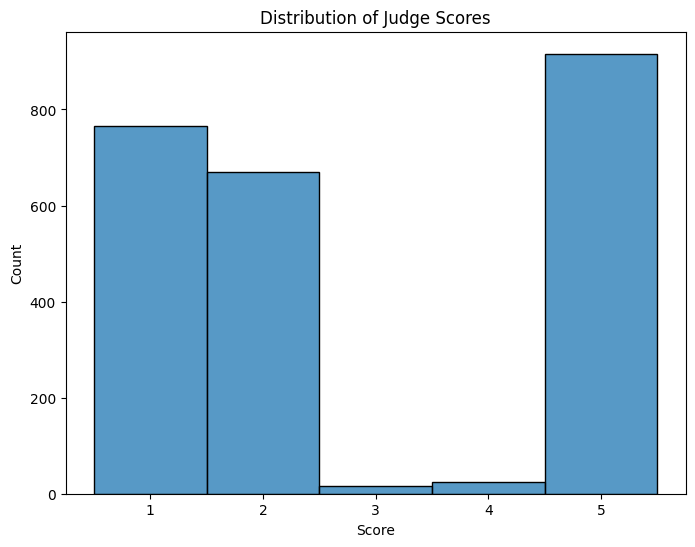

In [98]:
# Let's see the score distribution for all the predictions

plt.figure(figsize=(8, 6))
sns.histplot(data=judge_pred_df['score'], discrete=True)
plt.title('Distribution of Judge Scores')
plt.xlabel('Score')
plt.ylabel('Count')
plt.show()
